In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sliderule import sliderule,icesat2, earthdata
import pointCollection as pc
import datetime
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

In [6]:
# Load the data from CSV
data = pd.read_csv('permafrost_group1_community_buffers.csv')

# Function to create polygons from the corner points
def create_polygon(row):
    return Polygon([
        (row['Corner_1_Lon'], row['Corner_1_Lat']),
        (row['Corner_2_Lon'], row['Corner_2_Lat']),
        (row['Corner_3_Lon'], row['Corner_3_Lat']),
        (row['Corner_4_Lon'], row['Corner_4_Lat'])
    ])

# Create Polygons
data['polygon'] = data.apply(create_polygon, axis=1)

# Extract centroid coordinates for clustering
centroids = np.array([[poly.centroid.x, poly.centroid.y] for poly in data['polygon']])

# Cluster polygons based on centroids
clustering = DBSCAN(eps=2, min_samples=2).fit(centroids)
data['cluster'] = clustering.labels_

# Group by cluster and calculate the bounding rectangle for each cluster
rectangles = []
for cluster_id, group in data.groupby('cluster'):
    if cluster_id == -1:
        continue  # Skip noise points, if any
    
    polygons = group['polygon'].tolist()
    multi_polygon = MultiPolygon(polygons)
    envelope = multi_polygon.envelope
    bounds = envelope.bounds  # minx, miny, maxx, maxy
    
    # Calculate the mean distance between centroids within this cluster
    cluster_centroids = np.array([[poly.centroid.x, poly.centroid.y] for poly in polygons])
    distances = pdist(cluster_centroids)
    mean_distance = np.mean(distances)
    
    rectangles.append({
        "Cluster": cluster_id,
        "Min_Lon": bounds[0],
        "Min_Lat": bounds[1],
        "Max_Lon": bounds[2],
        "Max_Lat": bounds[3],
        "Num_Polygons": len(polygons),
        "Mean_Distance": mean_distance
    })

# Convert the result into a DataFrame
rectangles_df = pd.DataFrame(rectangles)

# Output the DataFrame with cluster information
print(rectangles_df)


   Cluster   Min_Lon  Min_Lat   Max_Lon  Max_Lat  Num_Polygons  Mean_Distance
0        0 -166.2953  59.6506 -161.8047  63.6228            15       2.412251
1        1 -157.4958  70.3675 -156.6887  71.3906             2       1.022773
2        2 -163.0728  65.8775 -159.9114  67.6767             7       1.696935
3        3 -157.2525  65.6008 -156.2914  66.9881             2       1.410303
4        4 -166.5897  64.4011 -165.3064  65.4356             2       1.367454


In [7]:
# Define a function to shrink the bounding box
def shrink_bounds(min_lon, min_lat, max_lon, max_lat, factor=0.1):
    #param factor: Shrink factor (e.g., 0.1 means shrinking the box by 10%)
    lon_diff = (max_lon - min_lon) * factor
    lat_diff = (max_lat - min_lat) * factor
    
    return (
        min_lon + lon_diff,  # New minimum longitude
        min_lat + lat_diff,  # New minimum latitude
        max_lon - lon_diff,  # New maximum longitude
        max_lat - lat_diff   # New maximum latitude
    )

# Shrink the bounding rectangles and create polygons
polygons = []

for _, row in rectangles_df.iterrows():
    # Shrink the bounding box
    min_lon, min_lat, max_lon, max_lat = shrink_bounds(
        row['Min_Lon'], row['Min_Lat'], row['Max_Lon'], row['Max_Lat'], factor=0.4  # Adjust factor as needed
    )
    
    # Create a smaller polygon using the shrunken bounds
    polygon = [
        {'lat': min_lat, 'lon': min_lon},  # Bottom-left corner
        {'lat': min_lat, 'lon': max_lon},  # Bottom-right corner
        {'lat': max_lat, 'lon': max_lon},  # Top-right corner
        {'lat': max_lat, 'lon': min_lon},  # Top-left corner
    ]
    polygons.append(polygon)

In [8]:
polygons[2]

[{'lat': 66.59718000000001, 'lon': -161.80823999999998},
 {'lat': 66.59718000000001, 'lon': -161.17596},
 {'lat': 66.95702, 'lon': -161.17596},
 {'lat': 66.95702, 'lon': -161.80823999999998}]

In [9]:
sliderule.init("slideruleearth.io", verbose=True);
parms = {
    "poly": polygons[2],
        "t0": '2019-06-06T00:00:00Z',
    "t1": '2019-08-12T00:00:00Z'
};

Client (version (4, 5, 3)) is out of date with the server (version (4, 6, 2))


In [10]:
atl06 = icesat2.atl06sp(parms).to_crs(3413)

Retry requested by https://sliderule.slideruleearth.io/source/atl06sp: cmr simplification requested
Using simplified polygon (for CMR request only!), 5 points using tolerance of 0.01
request <AppServer.12214> retrieved 7 resources from CMR
Starting proxy for atl06s to process 7 resource(s) with 7 thread(s)
request <AppServer.12333> processing initialized on ATL06_20190721123612_03580403_006_02.h5 ...
request <AppServer.12219> processing initialized on ATL06_20190622140017_13030303_006_02.h5 ...
request <AppServer.12204> processing initialized on ATL06_20190607031830_10670305_006_02.h5 ...
request <AppServer.12207> processing initialized on ATL06_20190710014600_01830405_006_02.h5 ...
request <AppServer.12165> processing initialized on ATL06_20190725122755_04190403_006_02.h5 ...
request <AppServer.12164> processing initialized on ATL06_20190611031010_11280305_006_02.h5 ...
request <AppServer.12135> processing initialized on ATL06_20190808002213_06250405_006_02.h5 ...
request <AppServer.1

In [11]:
atl06

,cycle,bsnow_conf,seg_azimuth,rgt,bsnow_h,sigma_geo_h,w_surface_window_final,tide_ocean,segment_id,dh_fit_dx,...,n_fit_photons,h_robust_sprd,spot,atl06_quality_summary,gt,r_eff,x_atc,y_atc,h_li,geometry
time,,,,,,,,,,,,,,,,,,,,,
2019-06-07 03:22:00.457439232,3,127,-173.467239,1067,NaN,0.136252,3.0,NaN,630523,0.000160,...,302,0.101744,5,0,50,0.721614,1.262934e+07,-3208.359863,6.410264,POINT (-2291195.074 1126214.161)
2019-06-07 03:22:00.460243968,3,127,-173.467270,1067,NaN,0.136557,3.0,NaN,630524,-0.001718,...,360,0.106348,5,0,50,0.896941,1.262936e+07,-3208.307617,6.379205,POINT (-2291212.131 1126225.045)
2019-06-07 03:22:00.463053568,3,127,-173.467300,1067,NaN,0.136418,3.0,NaN,630525,0.001134,...,403,0.108775,5,0,50,1.024453,1.262938e+07,-3208.242188,6.347086,POINT (-2291229.208 1126235.897)
2019-06-07 03:22:00.465866496,3,127,-173.467316,1067,NaN,0.136966,3.0,NaN,630526,-0.002828,...,448,0.099407,5,0,50,1.191898,1.262940e+07,-3208.134766,6.361240,POINT (-2291246.289 1126246.745)
2019-06-07 03:22:00.468683264,3,127,-173.467346,1067,NaN,0.136612,3.0,NaN,630527,0.002027,...,439,0.098424,5,0,50,1.157920,1.262942e+07,-3208.095703,6.343505,POINT (-2291263.364 1126257.599)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-08 00:25:46.498990336,4,127,-173.478989,625,NaN,0.134047,3.0,0.301152,631338,-0.000070,...,76,0.127897,6,0,60,0.746729,1.264574e+07,-3284.897949,5.421563,POINT (-2299947.092 1145658.805)
2019-08-08 00:25:46.501807872,4,127,-173.479004,625,NaN,0.135132,3.0,0.301152,631339,-0.003395,...,99,0.099874,6,0,60,1.042589,1.264576e+07,-3284.863281,5.399620,POINT (-2299964.103 1145669.782)
2019-08-08 00:25:46.504626432,4,127,-173.479034,625,NaN,0.134285,3.0,0.301152,631340,0.001631,...,121,0.096084,6,0,60,1.377428,1.264578e+07,-3284.841797,5.381838,POINT (-2299981.108 1145680.766)


In [12]:
print(f"originally found data with shape: {atl06.shape}")
atl06=atl06[atl06.atl06_quality_summary==0]
print(f"after subsetting, found data with shape: {atl06.shape}")


originally found data with shape: (28202, 21)
after subsetting, found data with shape: (26199, 21)


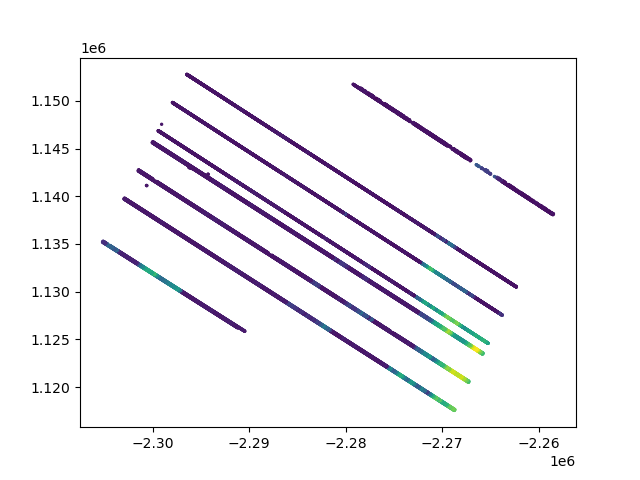

In [13]:
plt.figure()
plt.scatter(atl06.geometry.x, atl06.geometry.y, 2, c=atl06.h_li)

In [14]:
plt.colorbar()

In [59]:
# make a pointCollection.data object containing a subset of the data
# we will rename the h_li field to 'z' and the 'h_li_sigma' field to 'sigma'
D_full=pc.data().from_dict({field:np.array(atl06[field]) for field in ['spot','rgt','cycle','gt']})
D_full.assign({'x':np.array(atl06.geometry.x),
          'y':np.array(atl06.geometry.y), 
               'z':np.array(atl06.h_li),
               'sigma':np.array(atl06.h_li_sigma),
         't':np.array(atl06.index-datetime.datetime(2019, 6, 1))\
               .astype(float)/1.e9/24/3600/365.25+2019.5})



<class 'pointCollection.data.data'> with shape (26199,),
with fields:
['spot', 'rgt', 'cycle', 'gt', 'x', 'y', 'z', 'sigma', 't']

In [4]:
# reduce the data resolution to 80 m with a block median

_,rc_ind=pc.unique_by_rows(np.c_[D_full.cycle, D_full.rgt], return_dict=True)

D=[]
for rc, ind in rc_ind.items():
    D += [D_full[ind].blockmedian(80, 'z')]
D=pc.data().from_list(D)
print(D.summary())

NameError: name 'D_full' is not defined

In [61]:
D.t

array([2019.51681125, 2019.51681125, 2019.51681125, ..., 2019.68622267,
       2019.68622268, 2019.68622268])

In [2]:
D=pc.data().from_h5('ATL06_permafrost_group1_community_buffers.h5')

In [3]:
#D.to_h5('ATL06_permafrost_group1_community_buffers.h5')

In [4]:
dem = pc.grid.data().from_geotif('52_18_1_1_2m_v4.1_dem.tif')
dem_i = dem.interp(D.x,D.y)

In [5]:
dem_sub=dem[::10, ::10]

In [6]:
dem_i - D.z

array([       nan,        nan,        nan, ..., 0.44717789, 0.32563854,
       0.42552961])

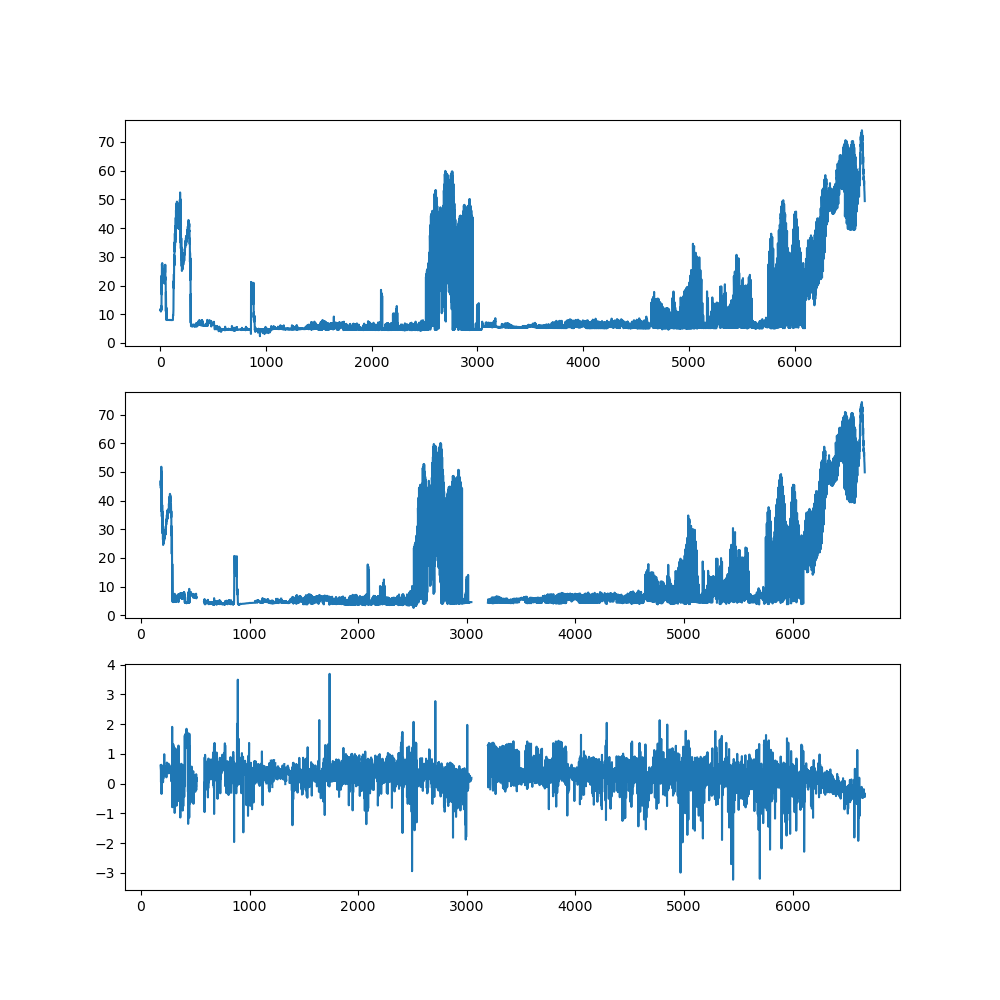

In [9]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (10,10)) 
ax1.plot(D.z)
# ax1.set_title('ATL06sp')
ax2.plot(dem_i)
# ax2.set_title('interpolated DEM')
ax3.plot(D.z-dem_i)
# ax3.set_title('Diff.')


In [ ]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1) 
ax1.plot(D.z)
# ax1.set_title('ATL06sp')
ax2.plot(dem_i)
# ax2.set_title('interpolated DEM')
ax3.plot(D.z-dem_i)
# ax3.set_title('Diff.')


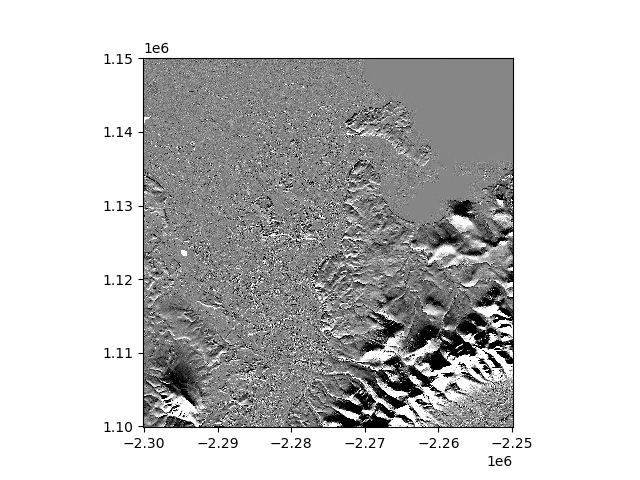

In [7]:
plt.figure()
dem.show(gradient=True)

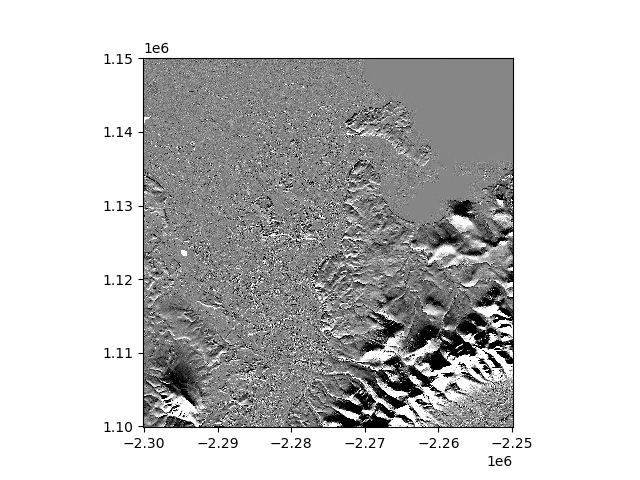

In [6]:
plt.figure()
dem.show(gradient=True)

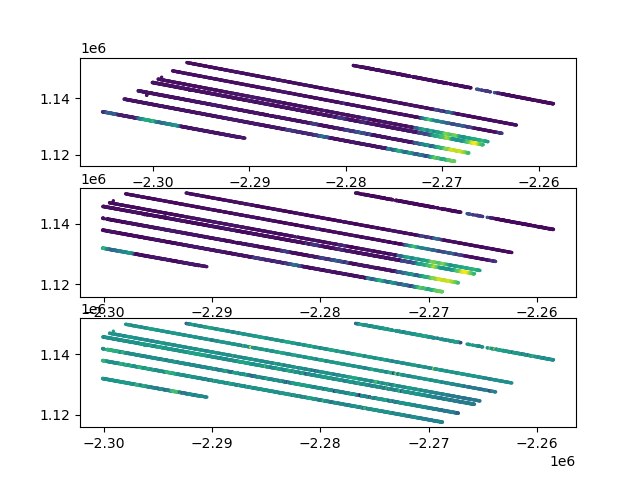

In [8]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1) 
ax1.scatter(D.x, D.y, 2, D.z)
# ax1.set_title('ATL06sp')
ax2.scatter(D.x, D.y, 2, dem_i)
# ax2.set_title('interpolated DEM')
ax3.scatter(D.x, D.y, 2, D.z-dem_i)
# ax3.set_title('Diff.')


In [9]:
dem=None

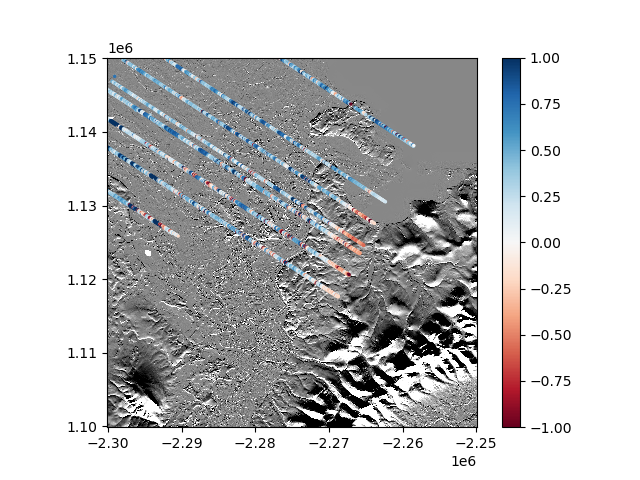

In [8]:
plt.figure()
dem_sub.show(gradient=True)
plt.scatter(D.x, D.y, 2, D.z-dem_i, label='ATL06sp', cmap='RdBu',rasterized=True, clim=[-1, 1] )
plt.colorbar()